In [1]:
import io
import shutil
import requests
import pandas as pd
import numpy as np
import csv
import glob
import os
from sklearn import linear_model
from datetime import datetime

def mask(df, key, value):
    return df[df[key] == value]

#turn off warnings
pd.options.mode.chained_assignment = None

## Import of Delay Data

In [2]:
listpaths = ['https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/03ec9d0a-b16f-4e78-8e4f-2da4970efbb6/download/fahrzeiten_soll_ist_20180325_20180331.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/c88a3801-c6fc-4d32-8ece-e269899be497/download/fahrzeiten_soll_ist_20180318_20180324.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/eb403fd1-8f8b-475e-98aa-f04ee3b255ba/download/fahrzeiten_soll_ist_20180311_20180317.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/1ac13127-fcde-4ac2-8462-50f348fd28fe/download/fahrzeiten_soll_ist_20180218_20180224.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/97e59d2a-83ec-438f-ae6f-0fe85d9bc1e6/download/fahrzeiten_soll_ist_20180304_20180310.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/b45b383e-4b0d-4ad0-8bee-e958c5e7360a/download/fahrzeiten_soll_ist_20180121_20180127.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/f17a950d-5be5-4b00-bafd-3c859afcc6cc/download/fahrzeiten_soll_ist_20180204_20180210.csv', 'https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd/resource/a38c5d0f-b732-4f5a-9786-eb01a2ffa0bb/download/fahrzeiten_soll_ist_20180211_20180217.csv']
frame = pd.DataFrame()
list_ = []
for path_ in listpaths:
    df = pd.read_csv(path_,index_col=None)
    list_.append(df)
df = pd.concat(list_)
# check size
check = pd.DataFrame(data=df)
col = check.shape[1]
row = check.shape[0]

print('delay data rows: %d' %row)
print('delay data columns: %d' %col)
# print(df)
print(df)
# for i in range(2):
#     s = requests.get(path.i).content
#     c = pd.read_csv(glob.glob(io.StringIO(s.decode('utf-8')[0]), index_col=None)
#     df = pd.DataFrame(data=c)

delay data rows: 12514055
delay data columns: 34
         linie  richtung betriebsdatum  fahrzeug  kurs  seq_von  \
0            2         1      25.03.18      2084     6        1   
1            2         1      25.03.18      3009     3        1   
2            2         1      25.03.18      3009     3        5   
3            2         1      25.03.18      3009     3        4   
4            2         1      25.03.18      3009     3        3   
5            2         1      25.03.18      3009     3        2   
6            2         1      25.03.18      2084     6        2   
7            2         1      25.03.18      2084     6        1   
8            2         1      25.03.18      3015     9        1   
9            2         1      25.03.18      3005     5        2   
10           2         1      25.03.18      3005     5        1   
11           2         1      25.03.18      3009     3        8   
12           2         1      25.03.18      3009     3        7   
13           

## Time difference calculation and formatting

In [4]:
df.drop(df.columns[[3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]], axis=1, inplace=True)
pd.DataFrame.mask = mask
df2 = df.mask('linie',69)

df2.loc[:,'diff'] = (df2['ist_an_von'] - df2['soll_an_von'])
dp = df2.copy()
dp.reset_index(drop=True, inplace=True)
dp.loc[:,'time'] = dp.loc[:,'soll_an_von'].copy().astype(float)
dp.loc[:,'time'] = pd.to_datetime(dp.loc[:,'time'], errors='coerce', unit='s')
dp.loc[:,'time'] = dp.loc[:,'time'].dt.strftime('%H:%M')
df1 = dp.copy()
df1.drop(dp.columns[[3, 4]], axis=1, inplace=True)
df1['time'] = pd.to_datetime(df1['betriebsdatum'] + ' ' + df1['time'])
df1.drop(df1.columns[[2]],axis=1, inplace = True)
df1.loc[:,'diff'] = df1.loc[:,'diff'].apply(pd.to_numeric, errors='coerce',downcast='float')
df1.loc[:,'time'] = df1.loc[:,'time'].dt.round('60min') 
df1 = df1.dropna(how='any') 
df1['diff'] = df1['diff'].astype(int)
df1 = df1.loc[df1['diff'] > 0]
df5 = df1.copy()
df5['diff'] = df5['diff']/60

check = pd.DataFrame(data=df1)
col = check.shape[1]
row = check.shape[0]

print('cleaned diff: %d' %row)
print('cleaned diff: %d' %col)
print(df1.head())
print(df1.dtypes)

cleaned diff: 103751
cleaned diff: 4
    linie  richtung  diff       time
6      69         2    11 2018-03-25
12     69         1     1 2018-03-25
13     69         1     8 2018-03-25
14     69         1     9 2018-03-25
18     69         1     7 2018-03-25
linie                int64
richtung             int64
diff                 int64
time        datetime64[ns]
dtype: object


## Weather Data

In [5]:
#input folder
path = r'./weather/*.csv'
#import csv as dataframe
new_cols = ['weather']
we = pd.read_csv('./weather/agrometeo-data.csv', encoding='Latin-1', header=None, names = new_cols)
# s = requests.get(glob.glob(path)).content
# c = pd.read_csv(glob.glob(io.StringIO(s.decode('utf-8')[0]), index_col=None))
# de = pd.DataFrame(data=c)
wet1 = pd.DataFrame(data = we)
#clean-up
wet = wet1.iloc[3:]
wet.loc[:,'time'] = wet.weather.str.split(';').str.get(0)
wet.loc[:,'temp'] = wet.weather.str.split(';').str.get(1)
wet.loc[:,'rain'] = wet.weather.str.split(';').str.get(2) 
wet.drop(wet.columns[[0]], axis=1, inplace = True)
wet.loc[:,'time'] = pd.to_datetime(wet.loc[:,'time'])
wet.loc[:,'rain'] = wet.loc[:,'rain'].apply(pd.to_numeric, errors='coerce')
wet = wet.dropna(how='any') 
#wet = wet.loc[wet['rain']*10]
#wet['rain'] = wet['rain'].astype(int)
#wet = wet.loc[wet['rain'] > 0]

q = wet.shape[1]
o = wet.shape[0]
print('weather data rows: %d'%o)  
print('weather data columns: %d'%q) 
print(wet.head())
print(wet.dtypes)

weather data rows: 8952
weather data columns: 3
                 time temp  rain
3 2017-04-18 00:00:00  2.8   0.0
4 2017-04-18 01:00:00  2.6   0.2
5 2017-04-18 02:00:00  3.5   0.0
6 2017-04-18 03:00:00  3.3   0.0
7 2017-04-18 04:00:00  2.5   0.0
time    datetime64[ns]
temp            object
rain           float64
dtype: object


## Matching Rain and Time Difference

In [6]:
# def nearest(items, pivot):
#     return min(items, key=lambda x: abs(x - pivot))
# df1.apply(nearest(wet.loc[:,'time'],df1.loc[:,'time']))
# df1.set_index(df1.loc[:,'time'], inplace=True)
# wet.set_index(wet.loc[:,'time'], inplace=True)

# print(df1.head())
# print(wet.head())

# left merge on both time col which are in datetime format
merge = df5.merge(wet, left_on='time', right_on='time', how='left')
                          
print(merge.head(3))
print(merge.dtypes)


# df1.iloc[df1.index.get_loc(wet.loc[:,'time'],method='nearest')]
# df1['time'] = pd.DatetimeIndex(wet['time']).normalize()
# df1.apply(lambda col: col.drop_duplicates().reset_index(drop=True))
# pred = pd.merge(df1, wet).head()


   linie  richtung      diff       time temp  rain
0     69         2  0.183333 2018-03-25  2.5   0.0
1     69         1  0.016667 2018-03-25  2.5   0.0
2     69         1  0.133333 2018-03-25  2.5   0.0
linie                int64
richtung             int64
diff               float64
time        datetime64[ns]
temp                object
rain               float64
dtype: object


## Correlation

   linie  richtung      diff  time temp  rain
0     69         2  0.183333     0  2.5   0.0
1     69         1  0.016667     0  2.5   0.0
linie                int64
richtung             int64
diff                 int64
time        datetime64[ns]
dtype: object


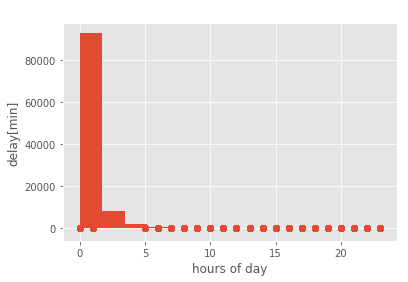

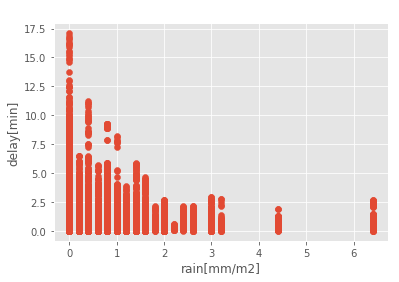

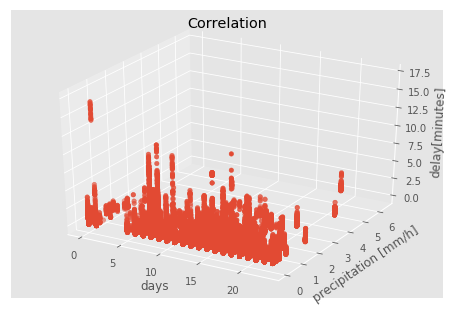

In [7]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn import svm
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D

# output folder
newpath = r'./output/'
if os.path.exists(newpath):
    shutil.rmtree(newpath, ignore_errors=True)
os.makedirs(newpath)

end = merge.copy()
# col = end.shape[1]
# row = end.shape[0]
# print(row)
# print(col)

end['time'] = end.loc[:,'time'].apply(lambda x: x.hour)
df4 = df5.copy()
df4['time'] = df4.loc[:,'time'].apply(lambda x: x.day)
print(end.head(2))
print(df1.dtypes)

## csvs to check
merge.to_csv('./output/merge.csv', header=False, index=False)
wet.to_csv('./output/wet.csv', header=False, index=False)
df1.to_csv('./output/df1.csv', header=False, index=False)

## frequency histogramm
plt.hist(end.loc[:,'diff'])
plt.title("delay frequency")
plt.xlabel("delay[minutes]")
plt.ylabel("number of occurences")

## 2D Figure
x = end.loc[:, 'time']
y = end.loc[:, 'diff']

plt.scatter(x, y)
plt.title(" ")
plt.xlabel("hours of day")
plt.ylabel("delay[min]")
plt.savefig('./output/2Dfrequency.png', format='png', dpi=800)
plt.show()

## 2D Figure
x = end.loc[:, 'rain']
y = end.loc[:, 'diff']

plt.scatter(x, y)
plt.title(" ")
plt.xlabel("rain[mm/m2]")
plt.ylabel("delay[min]")
plt.savefig('./output/2Dfigure.png', format='png', dpi=800)
plt.show()
## 3D Figure
x = end.loc[:,'time']
y = end.loc[:,'rain']
z = end.loc[:,'diff']

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)
# plt.scatter(x,y)
plt.title("Correlation")
ax.set_xlabel('days')
ax.set_ylabel('precipitation [mm/h]')
ax.set_zlabel('delay[minutes]')
plt.savefig('./output/3Dfigure.png', format='png', dpi=800)
plt.show()

###
# print(merge.loc[:,'rain'].describe())
# print(merge.loc[:,'diff'].describe())

# slope, intercept, r_value, p_value, std_err = stats.linregress(merge.loc[:,'rain'], merge.loc[:,'diff'])
# print("r-squared:", r_value**2)

## Prediction

In [ ]:
X = merge.loc[:,['rain']]
y = merge.loc[:,'diff']
from sklearn.svm import SVC
clf = SVC()
clf.fit(X, y)
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
pred = clf.predict(merge.loc[:,['rain']])
plt.scatter(merge.loc[:,['rain']],pred)
plt.ylabel('predicted delay [s]')
plt.xlabel('precipitation [mm/h]')
plt.savefig('./output/prediction.png', format='png', dpi=800)
plt.show()



# x_train = merge.loc[:,'rain']
# y_train = merge.loc[:,'diff']
# x_test = merge.loc[:,'rain']

# linear = linear_model.LinearRegression()
# linear.fit(x_train, y_train)
# linear.score(x_train, y_train)
# print('Coefficient: \n', linear.coef_)
# print('Intercept: \n', linear.intercept_)
# predicted= linear.predict(x_test)